After conducting a multi-linear regression, simple linear regression, and time-series analysis, I have concluded that the time-series analysis provided the most useful results. The results from the multi-linear regression and simple linear regression did not prove to be useful. Therefore, I have decided to only continue with the time-series analysis.

In [6]:
import pandas as pd

shelter_data = pd.read_csv('toronto-shelter-system-flow.csv')
shelter_flow_data = shelter_data.drop(labels='_id', axis=1)
shelter_flow_data['date(mmm-yy)'] = pd.to_datetime(shelter_flow_data['date(mmm-yy)'], format='%b-%y')
print(shelter_flow_data.head(3))

  date(mmm-yy) population_group  returned_from_housing  returned_to_shelter  \
0   2018-01-01   All Population                     46                  494   
1   2018-01-01          Chronic                     11                   29   
2   2018-01-01         Refugees                      4                   32   

   newly_identified  moved_to_housing  became_inactive  actively_homeless  \
0              1106               508              862               7958   
1               317               111              111               2532   
2               651               328               75               2408   

   ageunder16  age16-24  age25-34  age35-44  age45-54  age55-64  age65over  \
0        1233      1111      1341      1560      1318       973        422   
1         223       346       313       403       505       495        247   
2         914       241       414       547       204        66         22   

   gender_male  gender_female  gender_transgender,non-binary_

In [10]:
#create a subset of the data by selecting all the data that corresponds to "All Population" from the population_group column
y = shelter_flow_data[shelter_flow_data['population_group'] == 'All Population']["actively_homeless"]

In [16]:
#calculate the differences of the series for d=1
ydiff = y.shift(1) -y

In [17]:
#perform augmented Dickey-Fuller test to determine if the differences are stationary or not
from statsmodels.tsa.stattools import adfuller
adf = adfuller(ydiff[1:])
print(adf)

(-4.8011820096790405, 5.4103483192334465e-05, 0, 78, {'1%': -3.517113604831504, '5%': -2.8993754262546574, '10%': -2.5869547797501644}, 901.8510880165588)


Since the p-value of d=1 is 5.4103483192334465e-05, the differences are stationary and d is equal to 1.

<Axes: >

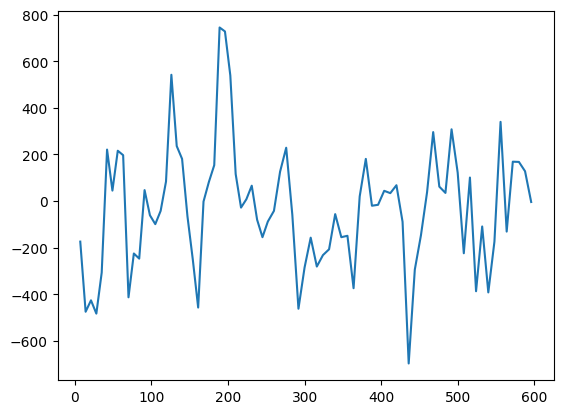

In [18]:
#Plotting the differences
ydiff.plot()

<ipython-input-19-2fff3d6c1879>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_population = shelter_flow_data['population_group'][0]


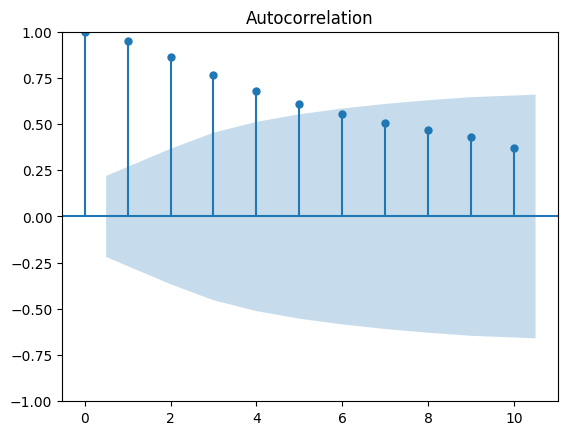

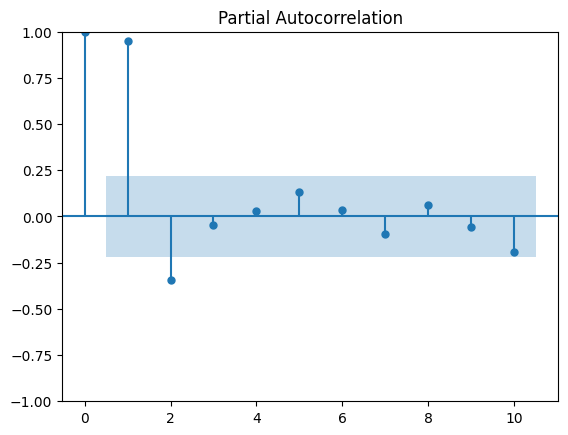

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

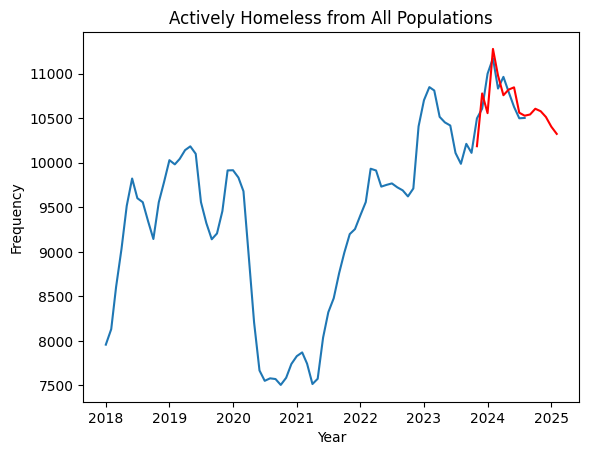

In [19]:
#import necessary libraries
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

#convert the date(mmm-yy) column into datetime format using pandas
shelter_flow_data['date(mmm-yy)'] = pd.to_datetime(shelter_flow_data['date(mmm-yy)'], format='%b-%y')

#set the date to be the index
shelter_flow_data = shelter_flow_data.set_index('date(mmm-yy)')

time_series = y

#plot ACF and PACF to determine ARIMA parameters
plot_acf(time_series, lags=10)
plt.show()
plot_pacf(time_series, lags=10)
plt.show()

#assign p, d, and q to the ARIMA model based on ACF/PACF plots and ADF
model = ARIMA(time_series, order=(3, 1, 5))
model_fit = model.fit()

#make predictions
predictions = model_fit.predict(start=len(time_series)-10, end=len(time_series)+5)

#plot the results
plt.plot(time_series, label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Actively Homeless from All Populations")
plt.show()

The ACF becomes insignificant after lag 5 which was how the q value was determined in the ARIMA model.

The PACF becomes insignificant after lag 3 which is how we determined our p value in the ARIMA model.

The ADF had a p-value of 0.22 which is greater than 0.05, therefore we fail to reject the null hypothesis and this means that the time series is non-stationary. After getting the first order difference, we found that this series is stationary. Therefore, our d value is 1.

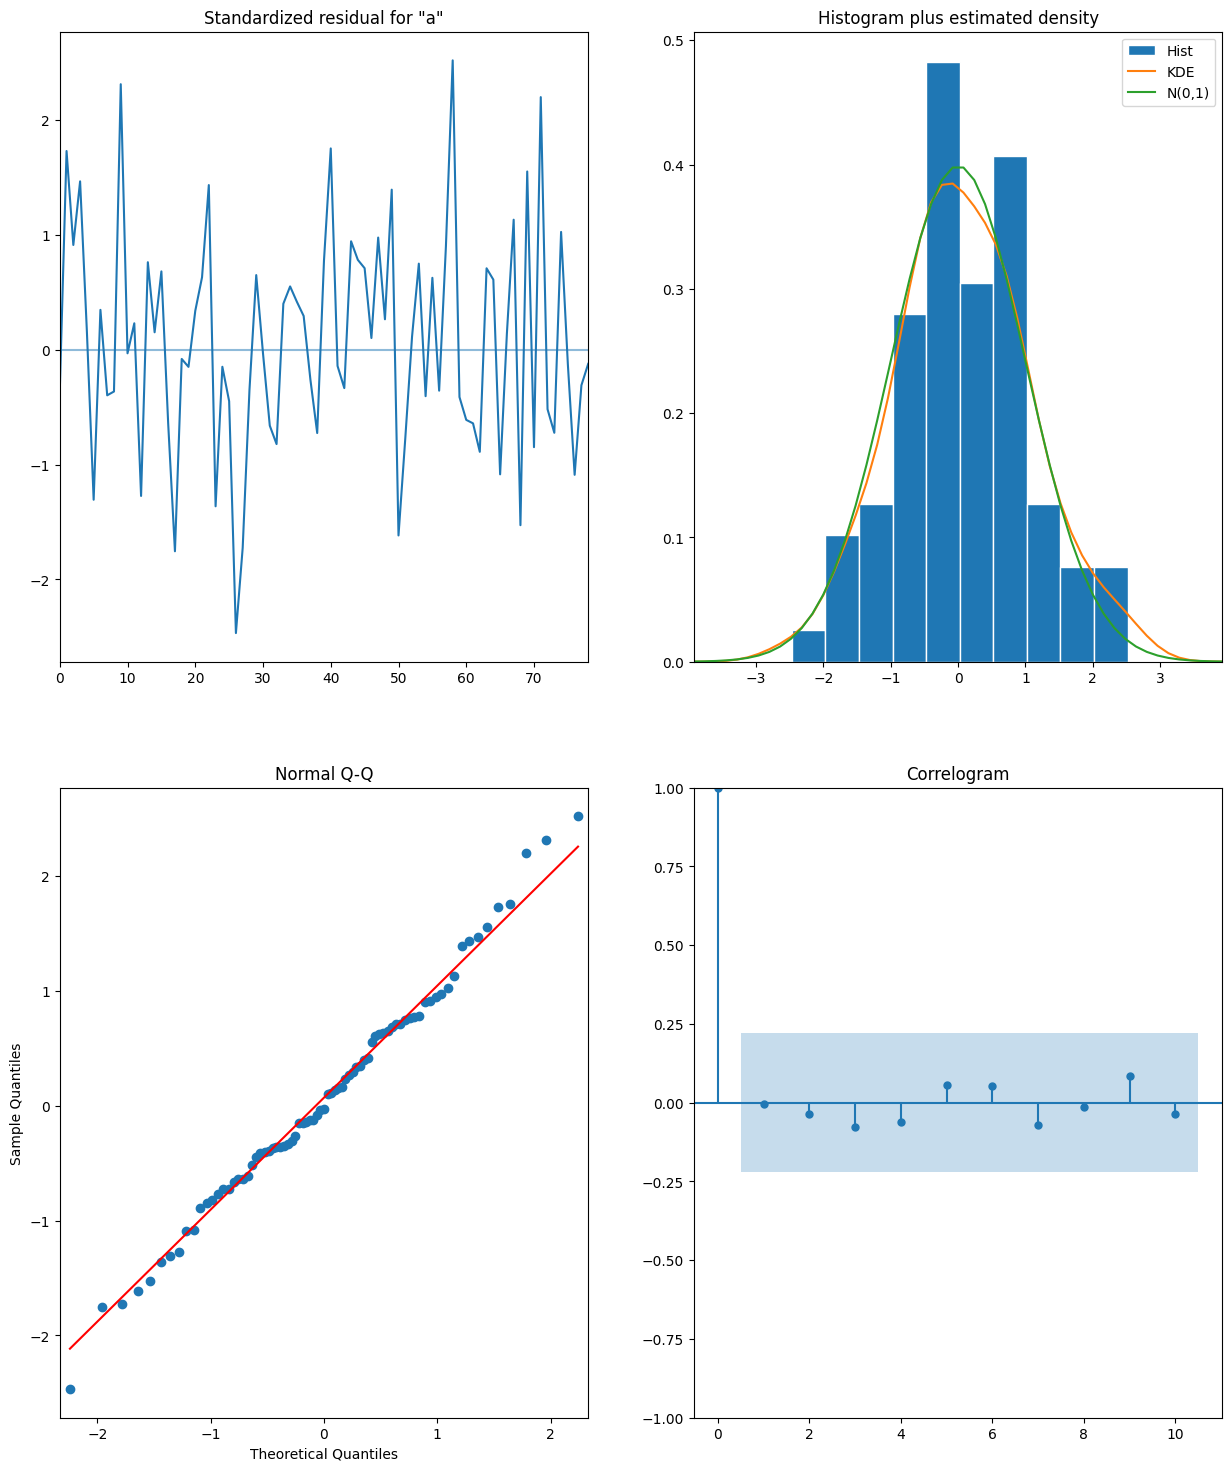

In [ ]:
model_fit.plot_diagnostics(figsize=(15, 18))
plt.show()